# CUSUM Filter for Event-Based Sampling

The **Cumulative Sum (CUSUM) filter** is used to detect significant deviations in a time series.  
It identifies points where the cumulative sum of log-returns crosses a given threshold $h$.  
This produces an *event-based sampling* scheme that focuses only on informative observations.

---

## Mathematical Formulation

We define a sequence of observations $\{y_t\}_{t=1}^T$ (e.g., log-returns).  
The CUSUM filter maintains two running statistics:

The update rules are given by   
$S_t^+ = \max\{0,\; S_{t-1}^+ + y_t\}, \quad S_0^+ = 0$  

and  

$S_t^- = \min\{0,\; S_{t-1}^- + y_t\}, \quad S_0^- = 0$.

At each time step $t$:

- If $S_t^+ \geq h$, an **event** is triggered and both $S_t^+$ and $S_t^-$ are reset to $0$.  
- If $|S_t^-| \geq h$, an **event** is triggered and both $S_t^+$ and $S_t^-$ are reset to $0$.

---

## Algorithm (as implemented in code)

1. Initialize $S^+ = 0$, $S^- = 0$.  
2. For each observation $y_t$:  
   - Update $S^+$ with $\max(0, S^+ + y_t)$.  
   - Update $S^-$ with $\min(0, S^- + y_t)$.  
3. If either statistic exceeds threshold $h$ in magnitude, record index $t$ as an event and reset both to $0$.  
4. Return the list of event indices.  

---

This procedure ensures that only **meaningful cumulative moves** in the series generate events, filtering out small fluctuations and noise.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] == 'Times New Roman'

import seaborn as sns
import yfinance as yf

import sys
sys.path.append("../src")
from CumSumFilter import CumSumFilter

In [2]:
import os
os.getcwd()

'C:\\Users\\USER\\PROJECTS\\Utilities\\notebooks'

# 1. Download Data

In [3]:
visa = yf.download('V',
                   start='2020-01-01',
                   end='2025-09-01')

C:\Users\USER\AppData\Local\Temp\ipykernel_23576\652905120.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  visa = yf.download('V',
[*********************100%***********************]  1 of 1 completed


In [4]:
close = visa['Close']
returns = (close / close.shift(1))[1:]
logs = np.log(returns)

# 2. Initialize `CumSumFilter`

#### Parameters
- **log_returns** : `np.ndarray`, `pd.Series`, or single-column `pd.DataFrame`  
  The input log-returns series to be filtered.

- **h** : `float`  
  Threshold for the cumulative sum. An event is triggered whenever the positive or negative accumulation crosses this level.

#### Output
The object provides:
- **indices** - The indices (or timestamps, if available) of detected events.  
- **filtered_events** - The corresponding log-return values at those event points.  

---

This allows us to focus only on **informative events** in the time series, rather than using every single observation.


In [5]:
H = 0.03
csf = CumSumFilter(logs, h=H)

## 2.1. `filter`

In [6]:
filtered = csf.filter()

# 3. Attributes
- **`index`**  
  Stores the original index of the input data.  
  If a `DatetimeIndex` is provided (e.g., from a pandas Series or DataFrame), it preserves the timestamps of the time series.

- **`filtered_events`**  
  Returns the log-return values at the points where the CUSUM filter has triggered an event.  
  These represent the *informative samples* selected from the series.

- **`events_index`**  
  Returns the integer positions of the detected events within the series.  
  These indices can be used to directly access rows in the original data

In [7]:
csf.index

DatetimeIndex(['2020-01-03', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10', '2020-01-13', '2020-01-14',
               '2020-01-15', '2020-01-16',
               ...
               '2025-08-18', '2025-08-19', '2025-08-20', '2025-08-21',
               '2025-08-22', '2025-08-25', '2025-08-26', '2025-08-27',
               '2025-08-28', '2025-08-29'],
              dtype='datetime64[ns]', name='Date', length=1422, freq=None)

In [8]:
events_values = csf.filtered_events
events_values[:10]

array([ 0.00801836,  0.01848948, -0.01627811,  0.01622024, -0.04539292,
        0.01590336,  0.01383833, -0.04917559, -0.05368191, -0.03921871])

In [9]:
events_index = csf.events_index
events_index[:10]

[6, 10, 15, 18, 19, 25, 29, 34, 35, 37]

# 4. Visual Example

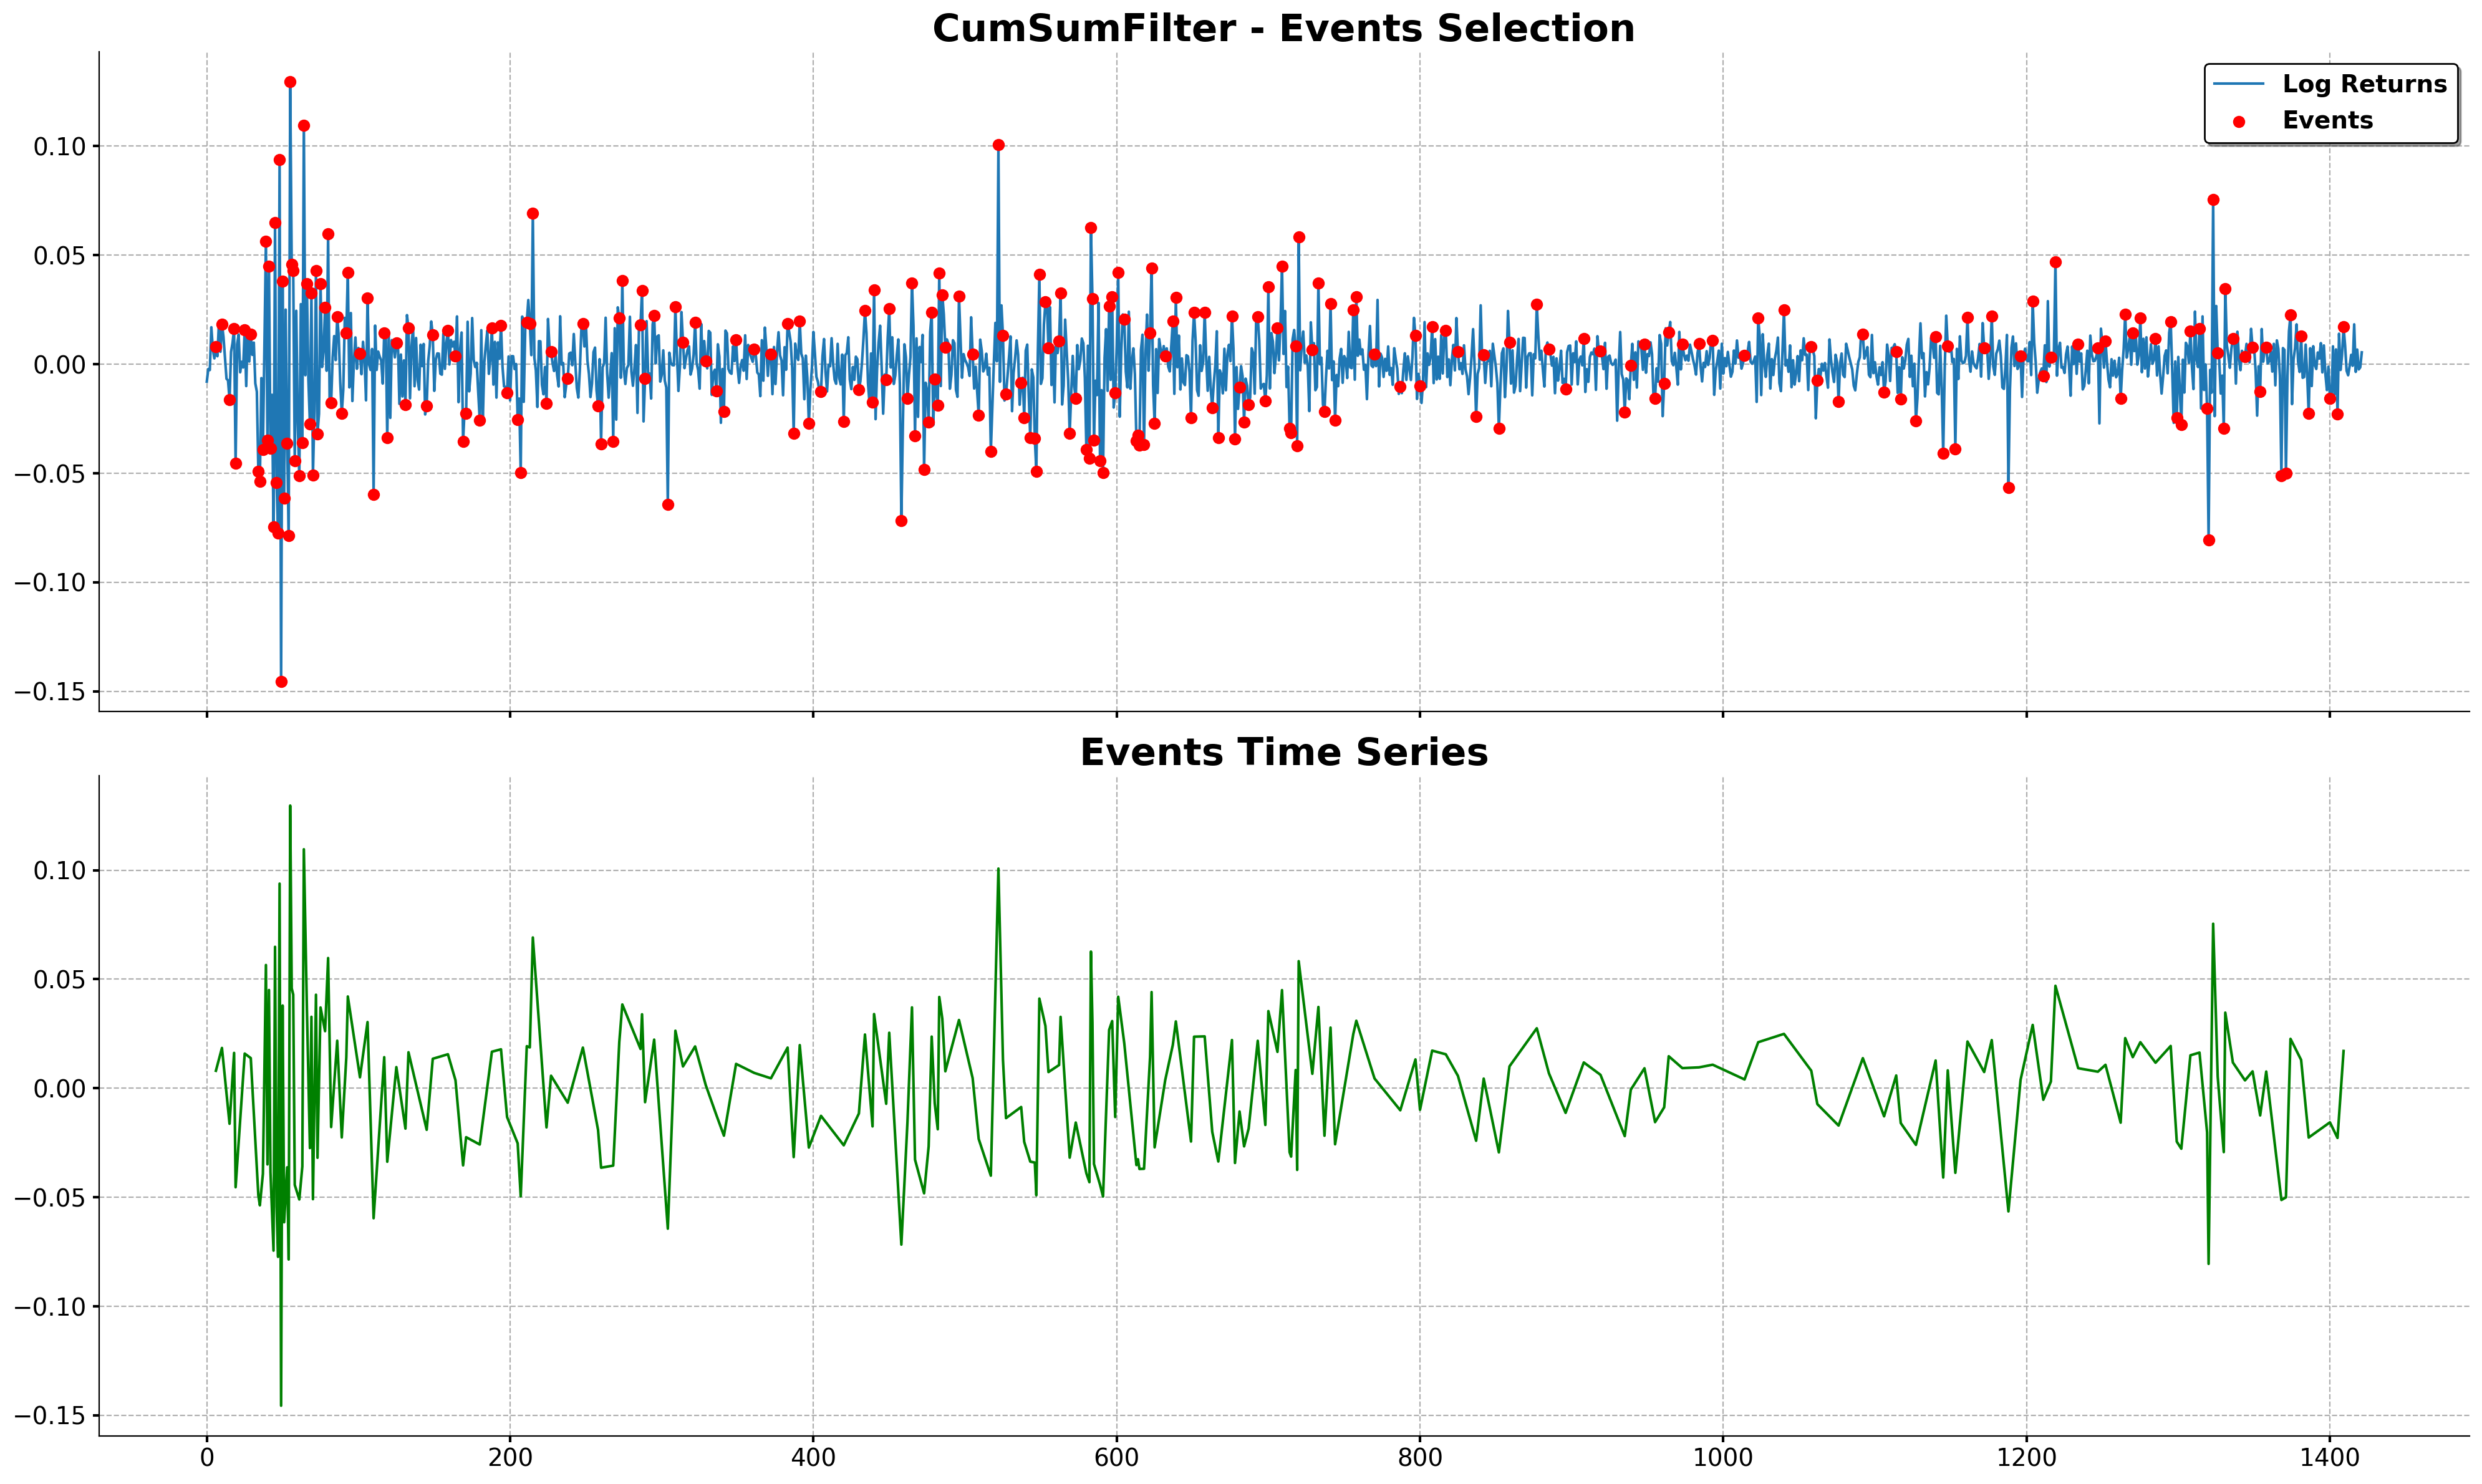

In [10]:
fig, axes = plt.subplots(2, 1, figsize=(20, 12), sharex=True, dpi=200)

axes[0].plot(logs.values, label="Log Returns")
axes[0].scatter(events_index, events_values, color="red", label="Events", zorder=2)
axes[0].set_title('CumSumFilter - Events Selection', size=22, weight='bold')
axes[0].legend(edgecolor='k', shadow=True, prop={'size': 14, 'weight': 'bold'})
axes[0].grid(ls='--')
axes[0].tick_params(axis='both', labelsize=14, width=1.5)
# for label in axes[0].get_xticklabels() + axes[0].get_yticklabels():
#     label.set_fontweight('bold')

axes[1].plot(events_index, events_values, color="green")
axes[1].set_title('Events Time Series', size=22, weight='bold')
axes[1].grid(ls='--')
axes[1].tick_params(axis='both', labelsize=14, width=1.5)
# for label in axes[1].get_xticklabels() + axes[1].get_yticklabels():
#     label.set_fontweight('bold')

sns.despine()
plt.tight_layout()
plt.show()